# MTL Hardware description

## MTL Composed of:
#####    - 2 Atoms quad
#####    - 2 Big cores
#####    - 1 GT
#####    - 1 Display
#####    - LLC & DDR memories
#####    - They are connected to Bus (1 port for quad)

In [1]:
# Platform modules
from asap.system_platform import Platform
from asap.hw import Clock, GlobalClock
from asap.states import ActiveState, PowerState, Condition, Expression, HierarchyState
from asap.ips import IP, Driver, ExecutingUnit, Port
from asap.buses import Bus
from asap.memories import Memory
from asap.strings import PENALTY, StateDesc

### Creating platform step by step - adding required IP states accordingly

#### System clocks

In [2]:
PENALTY_VAL = 1.13333

# Platform
sys_platform = Platform("MTL")

# Clocks
clk = GlobalClock("global_clk", 0.001).instance
a_clk = Clock("a_clk", 0.001)    # 1 ns
b_clk = Clock("b_clk", 0.001)    # 1 ns
g_clk = Clock("g_clk", 0.001)    # 1 ns
d_clk = Clock("d_clk", 0.001)    # 1 ns
sys_platform.add_clocks([clk, a_clk, b_clk, g_clk, d_clk])
system_light_sleep_cond = list()


#### Atoms

In [3]:
atoms = dict()
for atom_name in ["AtomQuad{}".format(i) for i in range(2)]:
    atom_sleep_conditions = list()
    p = Port(atom_name + "_p")
    dr = Driver("driver", a_clk)
    ex_units = list()
    for ex in ["ex_u{}".format(j) for j in range(4)]:
        ex_units.append(ExecutingUnit(ex, a_clk))
    

    atom = IP(atom_name, a_clk, ex_units, [dr], [p])
    for ex in ex_units:
        atom_sleep_conditions.append(Condition(ex, StateDesc.LESS_EQUAL, 'C6', negate=True))
    atom_sleep_conditions.append(Condition(dr, StateDesc.LESS_EQUAL, 'C6', negate=True))
    atom_sleep_exp = Expression('AtomSleep{}'.format(atom_name), atom_sleep_conditions)
    atom.ip_states = [
        HierarchyState('C0', idle_time=5),
        HierarchyState('C6', idle_time=5, expression=atom_sleep_exp),
    ]
    system_light_sleep_cond += atom_sleep_conditions
    
    atom.connect_driver(dr, p)
    atom.attach_attribute(PENALTY, PENALTY_VAL)
    sys_platform.add_ip(atom)
    atoms[atom_name] = (atom, p)

#### Big cores

In [4]:
# Big cores
bCores = dict()
for i in range(2):
    bCore_sleep_conditions = list()
    bCoreP = Port("BigCore{}_p".format(i))
    dr = Driver("driver", b_clk)
    ex_u = ExecutingUnit("ex_u", b_clk, 1)
    bCore = IP("BigCore{}".format(i), b_clk, [ex_u], [dr], [bCoreP])
    bCore.connect_driver(dr, bCoreP)
    bCore.attach_attribute(PENALTY, 1)
    
    bCore_sleep_conditions.append(Condition(ex_u, StateDesc.LESS_EQUAL, 'C6'))
    bCore_sleep_conditions.append(Condition(dr, StateDesc.LESS_EQUAL, 'C6'))
    bCore_sleep_exp = Expression('bCoresSleep{}'.format(i), bCore_sleep_conditions)
    system_light_sleep_cond += bCore_sleep_conditions
    bCore.ip_states =  [
        HierarchyState('C0', idle_time=5),
        HierarchyState('C6', idle_time=5, expression=bCore_sleep_exp),
    ]
    sys_platform.add_ip(bCore)
    bCores[bCore.name] = (bCore, bCoreP)


#### GT

In [5]:
# GT 
gt_p = Port('gt_p')
gt_dr = Driver('dr', g_clk)
gt_ex = ExecutingUnit('ex_u', g_clk)
gt = IP("GT", g_clk, [gt_ex], [gt_dr], [gt_p])
gt.connect_driver(gt_dr, gt_p)
sys_platform.add_ip(gt)

# GT states
gt_sleep_conditions = list()
gt_sleep_conditions.append(Condition(gt_ex, StateDesc.LESS_EQUAL, 'C6'))
gt_sleep_conditions.append(Condition(gt_dr, StateDesc.LESS_EQUAL, 'C6'))
gt_sleep_exp = Expression('GTSleep', gt_sleep_conditions)
system_light_sleep_cond += gt_sleep_conditions
gt.ip_states =  [
    HierarchyState('RC0', idle_time=1),
    HierarchyState('RC6', idle_time=1, expression=gt_sleep_exp),]


#### Display

In [6]:
# Display
display_p = Port('display_p')
display_ex = ExecutingUnit('ex_u', d_clk, )
display_dr = Driver('dr', d_clk)

display = IP("Disp", d_clk, [display_ex], [display_dr], [display_p])
display.connect_driver(display_dr, display_p)
sys_platform.add_ip(display)

# Building the display sleep expression
# only supports StateDesc.LESS_EQUAL or StateDesc.EQUAL
# negate attrbiute in condition - if you want it to be a not condition set as True
display_dr_sleep_cond = Condition(display_dr, StateDesc.LESS_EQUAL, 'C6')
display_ex_sleep_cond = Condition(display_ex, StateDesc.LESS_EQUAL, 'C6')
display_sleep_exp = Expression('DisplaySleep', [display_dr_sleep_cond, display_ex_sleep_cond]) # The connection between the conditions is AND
display_exec_sleep_exp = Expression('DisplayExecSleep', [display_ex_sleep_cond])

# By not setting an expression for the hierarchy state it sets the expression as always true expression
display.ip_states = [
    HierarchyState('DC0', idle_time=1),
    HierarchyState('DC1', idle_time=1, expression=display_exec_sleep_exp),
    HierarchyState('DC2', idle_time=1, expression=display_exec_sleep_exp),
    HierarchyState('DC2.1', idle_time=1, expression=display_exec_sleep_exp),
    HierarchyState('DC2.2', idle_time=1, expression=display_sleep_exp),
    HierarchyState('DC3', idle_time=1, expression=display_sleep_exp),
    HierarchyState('DC4', idle_time=1, expression=display_sleep_exp),
    HierarchyState('DC5', idle_time=1, expression=display_sleep_exp),
    HierarchyState('DC6', idle_time=1, expression=display_sleep_exp),
    HierarchyState('DC7', idle_time=1, expression=display_sleep_exp),
    HierarchyState('DC8', idle_time=1, expression=display_sleep_exp)
]  

#### Fabrics, Memories and Connectivities

In [7]:
# IP Buses
quad1_bus = Bus('quad1_bus', clk, 64)
quad2_bus = Bus('quad2_bus', clk, 64)
bBus1 = Bus('bBus1', clk, 64)
bBus2 = Bus('bBus2', clk, 64)

# System buses
bus1 = Bus('bus1', b_clk, 64)
bus2 = Bus('bus2', b_clk, 64)

sys_platform.add_buses([quad1_bus, quad2_bus, bBus1, bBus2, bus1, bus2])

# Memories
llc = Memory('LLC', clk, 1024)
ddr = Memory('DDR', clk, 1024)
sys_platform.add_memories([llc, ddr])

# Connecting
sys_platform.connect_to_bus(atoms["AtomQuad0"][1], quad1_bus)
sys_platform.connect_to_bus(atoms["AtomQuad1"][1], quad2_bus)

sys_platform.connect_to_bus(bCores["BigCore0"][1], bBus1)
sys_platform.connect_to_bus(bCores["BigCore1"][1], bBus2)

sys_platform.connect_to_bus(bBus1, bus1)
sys_platform.connect_to_bus(bBus2, bus1)
sys_platform.connect_to_bus(quad1_bus, bus1)
sys_platform.connect_to_bus(quad2_bus, bus1)
sys_platform.connect_to_bus(bus1, bus2)

sys_platform.connect_to_memory(bus1, llc)
sys_platform.connect_to_memory(bus2, ddr)
sys_platform.connect_to_bus(gt_p, bus2)
sys_platform.connect_to_bus(display_p, bus2)

sys_platform.validate_platform()

Validating System platform: MTL...
System platform is valid!


#### Fabric and memory states

#### System states

In [8]:
system_light_sleep_exp = Expression('SystemLightSleep', system_light_sleep_cond)
system_light_no_display_sleep_exp = Expression('SystemLightNoDisplaySleep', system_light_sleep_cond + [display_dr_sleep_cond])
system_heavy_sleep_exp = Expression('SystemHeavySleep', system_light_sleep_cond + [display_dr_sleep_cond, display_ex_sleep_cond])

# The order of the list is the order of the transition between system states
sys_platform.system_states = [
    HierarchyState('PC0', idle_time=1),
    HierarchyState('PC2', idle_time=1, expression=system_light_sleep_exp),
    HierarchyState('PC2R', idle_time=5, expression=system_light_sleep_exp),
    HierarchyState('PC3', idle_time=5, expression=system_light_no_display_sleep_exp),
    HierarchyState('PC6', idle_time=5, expression=system_light_no_display_sleep_exp),
    HierarchyState('PC7', idle_time=5, expression=system_light_no_display_sleep_exp),
    HierarchyState('PC8', idle_time=5, expression=system_light_no_display_sleep_exp),
    HierarchyState('PC9', idle_time=5, expression=system_heavy_sleep_exp),
    HierarchyState('PC10', idle_time=5, expression=system_heavy_sleep_exp),
]  


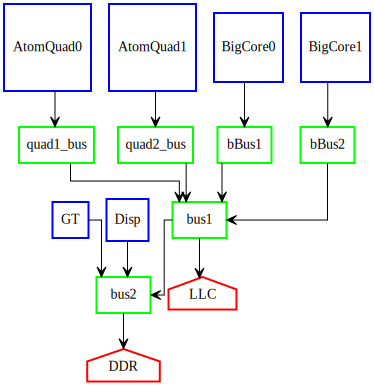

In [9]:
# Drawing platform
sys_platform

# Atom first system scheduler
##### Preferes to map task of map type "Core" to atoms first, if no atom is available then map to big cores
##### Tasks mapped to atom gets extra penalty

In [10]:
from asap.schedulers import SystemScheduler
from asap.mapping import MappingEntity
from asap.strings import SchedulingState

class AtomFirstScheduler(SystemScheduler):
    """
    Atom first scheduler:
        Prefers to map to Atoms first tasks w/ attribute MAP_TYPE == Core. Any task mapped to atom gets extra penalty.
        If all atoms are busy then map to CPU without any extra penalty.
    """
    def __init__(self, system_mgr, properties=None, platform_scheduler=None):
        super().__init__(system_mgr, properties, platform_scheduler)
        self._atoms = self._get_ips(['AtomQuad0', 'AtomQuad1'])
        self._bCores = self._get_ips(['BigCore0', 'BigCore1'])
        self._gt = self._get_ips(['GT'])[0]
        self._display = display

    def _get_ips(self, names):
        ips = list()
        for ip in self._system_mgr.sys_platform.ips:
            if ip.name in names:
                ips.append(ip)
        return ips

    def schedule_task(self, task, resource=None):
        """
        Schedule task according to task attribute MAP_TYPE.
        if MAP_TYPE is not defines on task then task will run unmapped
        """
        if resource is not None:
            return self._platform_scheduler.schedule_task(task, [MappingEntity(task, resource)])
        task_map_type = task.get_attribute('MAP_TYPE', None)
        if task_map_type is None:
            return self._platform_scheduler.schedule_task(task, list())
        elif task_map_type == 'GT':
            return self._platform_scheduler.schedule_task(task, [MappingEntity(task, self._gt)])
        elif task_map_type == 'Core':
            r, t = self._platform_scheduler.schedule_task(task, [MappingEntity(task, a) for a in self._atoms])
            if r is not None or t != SchedulingState.NAN:
                return r, t
            return self._platform_scheduler.schedule_task(task, [MappingEntity(task, b) for b in self._bCores])
        elif task_map_type == 'Display':
            return self._platform_scheduler.schedule_task(task, [MappingEntity(task, self._display)])
        else:
            return self._platform_scheduler.schedule_task(task, list())

    def on_task_finish(self, task):
        self._platform_scheduler.on_task_finish(task)


## Loading worklaod from PNML & adding display part to it

In [11]:
from asap.utils import create_rpw_task, from_pnml_file
from asap.workload import Task, Workload, TYPES
from asap.mapping import Mapping

pnml_path = '/nfs/iil/proj/dt/tmp_dna01/pumapa/pct/orkeren/notebooks/vpb_9.178_9.3118.extended.pnml'
# pnml_path = '/nfs/iil/proj/dt/vppnp01/work/saeedess/my_ws/SpeedSim/chrome_custom_browsing_tr_306.209_306.309_strict_tr_306.209_306.309_cluster_0.extended.pnml'

# Capability of adding dynamic attributes and mapping during load pnml
hw_resources = {'CPU': {'resource': atoms['AtomQuad0'][0], 'attributes': {'MAP_TYPE': 'Core', 'MEMORY_TARGET': 'DDR'}}, 'GT_GFX': {'resource': gt, 'attributes': {'MAP_TYPE': 'GT', 'MEMORY_TARGET': 'DDR'}}}
tasks_att = [{'hw_resource': {'values': ['CPU', 'GT_GFX'], 'function_data': {'function': create_rpw_task, 'metadata': {'split': 1}}}}]
workload, mapping = from_pnml_file(pnml_path, 'workload', hw_resources=hw_resources, tasks_att=tasks_att)

# Display part
# Display parameters
D_FPS = 60
SECOND = 1000000
PIXEL_BITS = 32
BUFF_SIZE = 512000
VSYNC_TIME = 100 / d_clk.period # 100 us
WAIT_TO_CYCLES = 500 / d_clk.period  # 500 us
NUMBER_OF_FILL_DRAIN_CYCLES = 10
FRAME_TIME = SECOND / D_FPS # one frame amount of time in us
FILL_DATA = (PIXEL_BITS * 1080 * 1920 / 8) / NUMBER_OF_FILL_DRAIN_CYCLES * 10 # data bytes for the fill task
CYCLE_TIME = (FRAME_TIME - WAIT_TO_CYCLES * d_clk.period) / NUMBER_OF_FILL_DRAIN_CYCLES

# Display TG
start = Task('d_start',TYPES.START, wait_delay=FRAME_TIME, iterations=1000000)
wait_to_cycles = Task('wait_to_cycles', TYPES.PROC, processing_cycles=WAIT_TO_CYCLES)
fill_task = Task('fill', type=TYPES.READ, read_bytes=FILL_DATA)
fill_task.attach_attribute('MAP_TYPE', 'Display')
fill_task.attach_attribute('DISPLAY_TYPE', 'fill')
fill_task.attach_attribute('MEMORY_TARGET', 'DDR')
drain_task = Task('drain', type=TYPES.PROC, processing_cycles=1000)
drain_task.attach_attribute('DISPLAY_TYPE', 'drain')
drain_task.attach_attribute('CYCLE_TIME', CYCLE_TIME)
vsync = Task('vsync', type=TYPES.PROC, processing_cycles=VSYNC_TIME)
vsync.attach_attribute('MAP_TYPE', 'Display')
end = Task('d_end',TYPES.END)
workload.add_tasks([start, fill_task, drain_task, vsync, wait_to_cycles, end])
workload.connect_tasks('start_to_vsync', start, vsync)
workload.connect_tasks('vsync_to_dummy_wait', vsync, wait_to_cycles)
workload.connect_tasks('dummy_to_fill', wait_to_cycles, fill_task, put_samples=NUMBER_OF_FILL_DRAIN_CYCLES, buf_size=NUMBER_OF_FILL_DRAIN_CYCLES)
workload.connect_tasks('fill_to_drain', fill_task, drain_task)
workload.connect_tasks('drain_to_fill_feedback', drain_task, fill_task, init=1)
workload.connect_tasks('drain_to_end', drain_task, end)
mapping.map_task(fill_task, display)
mapping.map_task(vsync, display)


## Simulating Workload on MTL hardware with APM and Atom first sched

In [12]:
%%time
from notebooks.MTL.mtl_near_far_fabric import MTLNearFarFabric
from models.power.apm.apm import APM, SpeedSimListener
from models.power.apm.updater import Updater
from speedsim import SpeedSim

speedsim = SpeedSim(sys_platform, workload, mapping)
speedsim.set_sim_scheduler(APM)
speedsim.set_system_scheduler(AtomFirstScheduler)
speedsim.add_extension('MTLNearFarFabric', MTLNearFarFabric)
listener = SpeedSimListener()
updater = Updater(listener, apm=speedsim.sim_scheduler)
speedsim.sim_scheduler.instantiate(updater, listener, heart_beat=0.1)
res = speedsim.simulate(150000)


CPU times: user 12.6 s, sys: 104 ms, total: 12.7 s
Wall time: 13.2 s


## Simulation results
#### Task analysis table

In [13]:
res

,START,FINISH,TRANSITION,RESOURCE,RESOURCE_IDX,DURATION
0,0.000000,0.000000,6/dxgkrnl.sys!DpiFdoDpcForIsr_-1_-1_id_0_0/read,NULL,0,0.000000
1,0.000000,1.267063,6/dxgkrnl.sys!DpiFdoDpcForIsr_-1_-1_id_0_0/pro...,AtomQuad0/ex_u0,0,1.267063
2,1.267063,1.267063,6/dxgkrnl.sys!DpiFdoDpcForIsr_-1_-1_id_0_0/write,NULL,0,0.000000
3,1.267063,1.267063,7/dxgkrnl.sys!DpiFdoDpcForIsr_-1_-1_id_0_1/read,NULL,0,0.000000
4,1.267063,1.267063,8/dwm.exe_716_1272_id_1_0/read,NULL,0,0.000000
5,1.267063,33.512568,7/dxgkrnl.sys!DpiFdoDpcForIsr_-1_-1_id_0_1/pro...,AtomQuad0/ex_u0,0,32.245505
6,33.512568,33.512568,7/dxgkrnl.sys!DpiFdoDpcForIsr_-1_-1_id_0_1/write,NULL,0,0.000000
7,1.267063,87.289077,8/dwm.exe_716_1272_id_1_0/process,AtomQuad0/ex_u1,0,86.022014
8,87.289077,87.289077,8/dwm.exe_716_1272_id_1_0/write,NULL,0,0.000000
9,0.000000,100.000000,vsync,Disp/ex_u,0,100.000000


In [14]:
from post_processing.utils import create_task_analysis_fig
from bokeh.plotting import show, output_notebook
output_notebook()

clear_results = res[res['RESOURCE'] != 'NULL']
fig = create_task_analysis_fig(clear_results)
show(fig)

Loading BokehJS ...

#### BW data

In [15]:
bw_ip, bw_bus = speedsim.get_extension('MTLNearFarFabric').get_bw_events()
bw_ip

,TIME,RESOURCE,BW,TARGET
0,602.000000,Disp,64000.0,DDR
1,731.600000,Disp,64000.0,DDR
2,2220.700000,Disp,64000.0,DDR
3,2350.300000,Disp,64000.0,DDR
4,3839.400000,Disp,64000.0,DDR
5,3969.000000,Disp,64000.0,DDR
6,5458.100000,Disp,64000.0,DDR
7,5587.700000,Disp,64000.0,DDR
8,7076.800000,Disp,64000.0,DDR
9,7206.400000,Disp,64000.0,DDR


In [16]:
bw_bus

,TIME,BUS,BW
0,602.000000,bus2,64000.0
1,602.000000,bus2,64000.0
2,731.600000,bus2,64000.0
3,2220.700000,bus2,64000.0
4,2220.700000,bus2,64000.0
5,2350.300000,bus2,64000.0
6,3839.400000,bus2,64000.0
7,3839.400000,bus2,64000.0
8,3969.000000,bus2,64000.0
9,5458.100000,bus2,64000.0


#### Effective bandwidth tables

In [17]:
from asap.strings import ResourceDesc

bus_interval_bandwidth = speedsim.get_extension('MTLNearFarFabric').get_effective_bandwidth_table(ResourceDesc.BUS, intervals=10)

bus_interval_bandwidth

,0.00-14999.99,14999.99-29999.98,29999.98-44999.97,44999.97-59999.96,59999.96-74999.95,74999.95-89999.94,89999.94-104999.93,104999.93-119999.92,119999.92-134999.91,134999.91-149999.90
bus2,5843.204495,5313.902942,5118.368879,4976.643318,5060.865440,4976.643318,4976.643318,4976.643318,4976.643318,4976.643318
quad1_bus,121.862748,0.000000,141.725561,0.000000,84.222123,0.000000,0.000000,0.000000,0.000000,0.000000
bus1,121.862748,0.000000,141.725561,0.000000,84.222123,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
mem_interval_bandwidth = speedsim.get_extension('MTLNearFarFabric').get_effective_bandwidth_table(ResourceDesc.MEMORY, intervals=10)

mem_interval_bandwidth

,0.00-14999.99,14999.99-29999.98,29999.98-44999.97,44999.97-59999.96,59999.96-74999.95,74999.95-89999.94,89999.94-104999.93,104999.93-119999.92,119999.92-134999.91,134999.91-149999.90
DDR,5843.204495,5313.902942,5118.368879,4976.643318,5060.86544,4976.643318,4976.643318,4976.643318,4976.643318,4976.643318


In [19]:
driver_interval_bandwidth = speedsim.get_extension('MTLNearFarFabric').get_effective_bandwidth_table(ResourceDesc.DRIVER, intervals=10)

driver_interval_bandwidth

,0.00-14999.99,14999.99-29999.98,29999.98-44999.97,44999.97-59999.96,59999.96-74999.95,74999.95-89999.94,89999.94-104999.93,104999.93-119999.92,119999.92-134999.91,134999.91-149999.90
Disp/dr,4976.643318,4976.643318,4976.643318,4976.643318,4976.643318,4976.643318,4976.643318,4976.643318,4976.643318,4976.643318
GT/dr,744.698430,337.259625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BigCore1/driver,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BigCore0/driver,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AtomQuad1/driver,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AtomQuad0/driver,121.862748,0.000000,141.725561,0.000000,84.222123,0.000000,0.000000,0.000000,0.000000,0.000000


#### Frequency data

In [20]:
frequency_data = speedsim.sim_scheduler.get_frequency_data()
frequency_data

""


#### Resources power states results

In [21]:
states = speedsim.sim_scheduler.get_states_data()
states

,TIME,RESOURCE,STATE
0,0.000000,AtomQuad0/driver,ACTIVE
1,0.000000,AtomQuad0/ex_u0,ACTIVE
2,0.000000,AtomQuad0/ex_u1,ACTIVE
3,0.000000,AtomQuad0/ex_u2,ACTIVE
4,0.000000,AtomQuad0/ex_u3,ACTIVE
5,0.000000,AtomQuad1/driver,ACTIVE
6,0.000000,AtomQuad1/ex_u0,ACTIVE
7,0.000000,AtomQuad1/ex_u1,ACTIVE
8,0.000000,AtomQuad1/ex_u2,ACTIVE
9,0.000000,AtomQuad1/ex_u3,ACTIVE


In [22]:
from bokeh.plotting import gridplot
from post_processing.utils import create_states_figs
state_graphs = create_states_figs(states)
show(gridplot(state_graphs))

#### Resource power states residency

In [23]:
from post_processing.utils import create_states_residency

power_states_residency = create_states_residency(states, speedsim.get_sim_time(), intervals=1)
power_states_residency

,0.00-149999.90
AtomQuad0/driver_ACTIVE,0.161333
AtomQuad0/driver_C6,99.838667
AtomQuad0/ex_u0_ACTIVE,5.429404
AtomQuad0/ex_u0_C6,94.570596
AtomQuad0/ex_u1_ACTIVE,3.672869
AtomQuad0/ex_u1_C6,96.327131
AtomQuad0/ex_u2_ACTIVE,0.927067
AtomQuad0/ex_u2_C6,99.072933
AtomQuad0/ex_u3_ACTIVE,0.214200
AtomQuad0/ex_u3_C6,99.785800


#### System, ip, memory and buses states

In [24]:
system_states = speedsim.sim_scheduler.get_system_states_data()
system_states

,TIME,RESOURCE,STATE
0,0.000000,DDR,ACTIVE
1,0.000000,LLC,ACTIVE
2,0.000000,bBus1,ACTIVE
3,0.000000,bBus2,ACTIVE
4,0.000000,bus1,ACTIVE
5,0.000000,bus2,ACTIVE
6,0.000000,quad1_bus,ACTIVE
7,0.000000,quad2_bus,ACTIVE
8,0.100000,GT,RC0
9,0.100000,Disp,DC0


In [25]:
ex = system_states[system_states['RESOURCE'] == 'DDR']
ex

,TIME,RESOURCE,STATE
0,0.000000,DDR,ACTIVE
15,16.100000,DDR,C6
46,601.000000,DDR,ACTIVE
49,747.600000,DDR,C6
68,2219.700000,DDR,ACTIVE
71,2366.400000,DDR,C6
90,3838.400000,DDR,ACTIVE
93,3985.100000,DDR,C6
112,5457.100000,DDR,ACTIVE
115,5603.700000,DDR,C6


In [26]:
ex2 = system_states[system_states['RESOURCE'] == 'LLC']
ex2

,TIME,RESOURCE,STATE
1,0.000000,LLC,ACTIVE
16,16.100000,LLC,C6
160,8603.100000,LLC,ACTIVE
164,8636.200000,LLC,C6
171,8663.000000,LLC,ACTIVE
174,8680.200000,LLC,C6
196,9630.700000,LLC,ACTIVE
199,9660.100000,LLC,C6
500,33284.100000,LLC,ACTIVE
505,33304.100000,LLC,C6


In [27]:
state_graphs = create_states_figs(system_states)
show(gridplot(state_graphs))

In [28]:
system_states_residency = create_states_residency(system_states, speedsim.get_sim_time(), intervals=1)
system_states_residency

,0.00-149999.90
DDR_ACTIVE,9.168673
DDR_C6,90.831327
LLC_ACTIVE,0.167333
LLC_C6,99.832667
bBus1_ACTIVE,0.010733
bBus1_C6,99.989267
bBus2_ACTIVE,0.010733
bBus2_C6,99.989267
bus1_ACTIVE,0.167333
bus1_C6,99.832667


### IP Residency table

In [29]:
from post_processing.utils import get_hw_analysis
from asap.strings import ResourceDesc

# get_hw_analysis resturn time table and residency table according to required resource type
ips_time_table, ips_residency_table = get_hw_analysis(ResourceDesc.IP, intervals=10)
ips_residency_table

,0.00-14999.99,14999.99-29999.98,29999.98-44999.97,44999.97-59999.96,59999.96-74999.95,74999.95-89999.94,89999.94-104999.93,104999.93-119999.92,119999.92-134999.91,134999.91-149999.90
AtomQuad0/ex_u0,40.914669,6.171423,3.320561,0.121319,0.491110,0.589340,0.377905,0.104433,0.598285,0.000000
AtomQuad0/ex_u1,26.181912,4.844075,0.569665,0.000000,2.500891,0.000000,0.398842,0.000000,0.210528,0.000000
Disp/ex_u,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.000000
Disp/dr,7.994672,7.776005,7.776005,7.776005,7.776005,7.776005,7.776005,7.776005,7.776005,7.776005
AtomQuad0/driver,0.190411,0.000000,0.221446,0.000000,0.131597,0.000000,0.000000,0.000000,0.000000,0.000000
AtomQuad0/ex_u2,5.578103,1.458249,0.000000,0.000000,0.177744,0.000000,0.000000,0.000000,0.000000,0.000000
AtomQuad0/ex_u3,1.387242,0.219118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AtomQuad1/ex_u1,3.261031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AtomQuad1/ex_u0,14.546232,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GT/dr,1.382258,0.526968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [30]:
# get_hw_analysis resturn time table and residency table according to required resource type
memory_time_table, memory_residency_table = get_hw_analysis(ResourceDesc.MEMORY, intervals=1)
memory_residency_table

,0.00-149999.90
DDR,7.999407


In [31]:
memory_time_table.head(10)

,START,FINISH,RESOURCE,DURATION
0,602.0,731.600000,DDR,129.600000
1,2220.7,2350.300000,DDR,129.600000
2,3839.4,3969.000000,DDR,129.600000
3,5458.1,5587.700000,DDR,129.600000
4,7076.8,7206.400000,DDR,129.600000
5,8604.1,8620.117797,DDR,16.017797
6,8664.0,8664.147391,DDR,0.147391
7,8695.5,8825.100000,DDR,129.600000
8,9631.7,9644.096375,DDR,12.396375
9,10314.2,10443.800000,DDR,129.600000


In [32]:
from post_processing.utils import create_resource_fig

memory_time_table, memory_residency_table = get_hw_analysis(ResourceDesc.MEMORY, intervals=1)
mem_fig = create_resource_fig(memory_time_table)
show(mem_fig)